# Tema 1 - Clasificare de Imagini
Mîrza Ana-Maria 341C1

Scopul acestei teme este de a explora modalități de clasificare a imaginilor prin compararea diferitelor modele de antrenare și a extragerilor de atribute. Pentru rezolvarea temei se vor urma următorii pași:
* Vizualizarea și "explorarea" datelor
* Extragerea atribuțiilor din setul de date
* Evaluarea mai multor modele pentru găsirea soluției celei mai bune pentru problema dată

## Setul de date
Vom lucra cu seturile de date [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) și [Fruits-360](https://www.kaggle.com/datasets/moltean/fruits), un set de date RGB cu 70 de tipuri diferite de fructe, legume și nuci. Fashion-MNIST conține imagini cu articole vestimentare în format greyscale. Etichetele din setul de date Fashion-MNIST sunt:

Label - Description 

0  - T-shirt/top

1  - Trouser

2  - Pullover

3  - Dress

4  - Coat

5  - Sandal

6  - Shirt

7  - Sneaker

8  - Bag

9  - Ankle boot



## Fruits-360

### Procesare Set de Date

In [1]:
# Structuri de date și unelte de analiză
import numpy as np
import pandas as pd
import cv2
import glob
import os
import string

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils.multiclass import unique_labels
from sklearn import metrics
from sklearn.svm import SVC

# Vizualizare
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from mlxtend.plotting import plot_decision_regions
from mpl_toolkits.mplot3d import Axes3D

dim = 100

In [2]:
def getYourFruits(fruits, data_type, print_n=False, k_fold=False):
    images = []
    labels = []
    val = ['Training', 'Test']
    if not k_fold:
        path = "./input/fruits-360/" + data_type + "/"
        for i,f in enumerate(fruits):
            j=0

            paths = [path + entry.name for entry in os.scandir(path) 
                 if entry.is_dir() and entry.name.startswith(f)]
            for p in paths:
                for image_path in glob.glob(os.path.join(p, "*.jpg")):
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                    image = cv2.resize(image, (dim, dim))
                    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                    images.append(image)
                    labels.append(i)
                    j+=1
            if(print_n):
                print("There are " , j , " " , data_type.upper(), " images of " , fruits[i].upper())
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    else:
        for v in val:
            path = "./input/fruits-360/" + v + "/"
            for i,f in enumerate(fruits):
                p = path + f
                j=0

                paths = [path + entry.name for entry in os.scandir(path) 
                            if entry.is_dir() and entry.name.startswith(f)]
                for p in paths:
                    for image_path in glob.glob(os.path.join(p, "*.jpg")):
                        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
                        image = cv2.resize(image, (dim, dim))
                        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
                        images.append(image)
                        labels.append(i)
                        j+=1
        images = np.array(images)
        labels = np.array(labels)
        return images, labels
    
def getAllFruits():
    fruits = []
    for fruit_path in glob.glob("./input/fruits-360/Training/*"):
        fruit = fruit_path.split("/")[-1].split(" ")[0]
        if fruit not in fruits:
            fruits.append(fruit)
    return fruits

In [3]:
#Choose your Fruits
fruits = ['Pineapple' , 'Cocos', 'Carrot', 'Guava']
# fruits = getAllFruits()

#Get Images and Labels 
X_t, y_train =  getYourFruits(fruits, 'Training', print_n=True, k_fold=False)
X_testt, y_test = getYourFruits(fruits, 'Test', print_n=True, k_fold=False)

#Scale Data Images
scaler = StandardScaler()
X_train = scaler.fit_transform([i.flatten() for i in X_t])
X_test = scaler.fit_transform([i.flatten() for i in X_testt])
# X = scaler.fit_transform([i.flatten() for i in X])

There are  983   TRAINING  images of  PINEAPPLE
There are  490   TRAINING  images of  COCOS
There are  151   TRAINING  images of  CARROT
There are  490   TRAINING  images of  GUAVA
There are  329   TEST  images of  PINEAPPLE
There are  166   TEST  images of  COCOS
There are  50   TEST  images of  CARROT
There are  166   TEST  images of  GUAVA


Pineapple


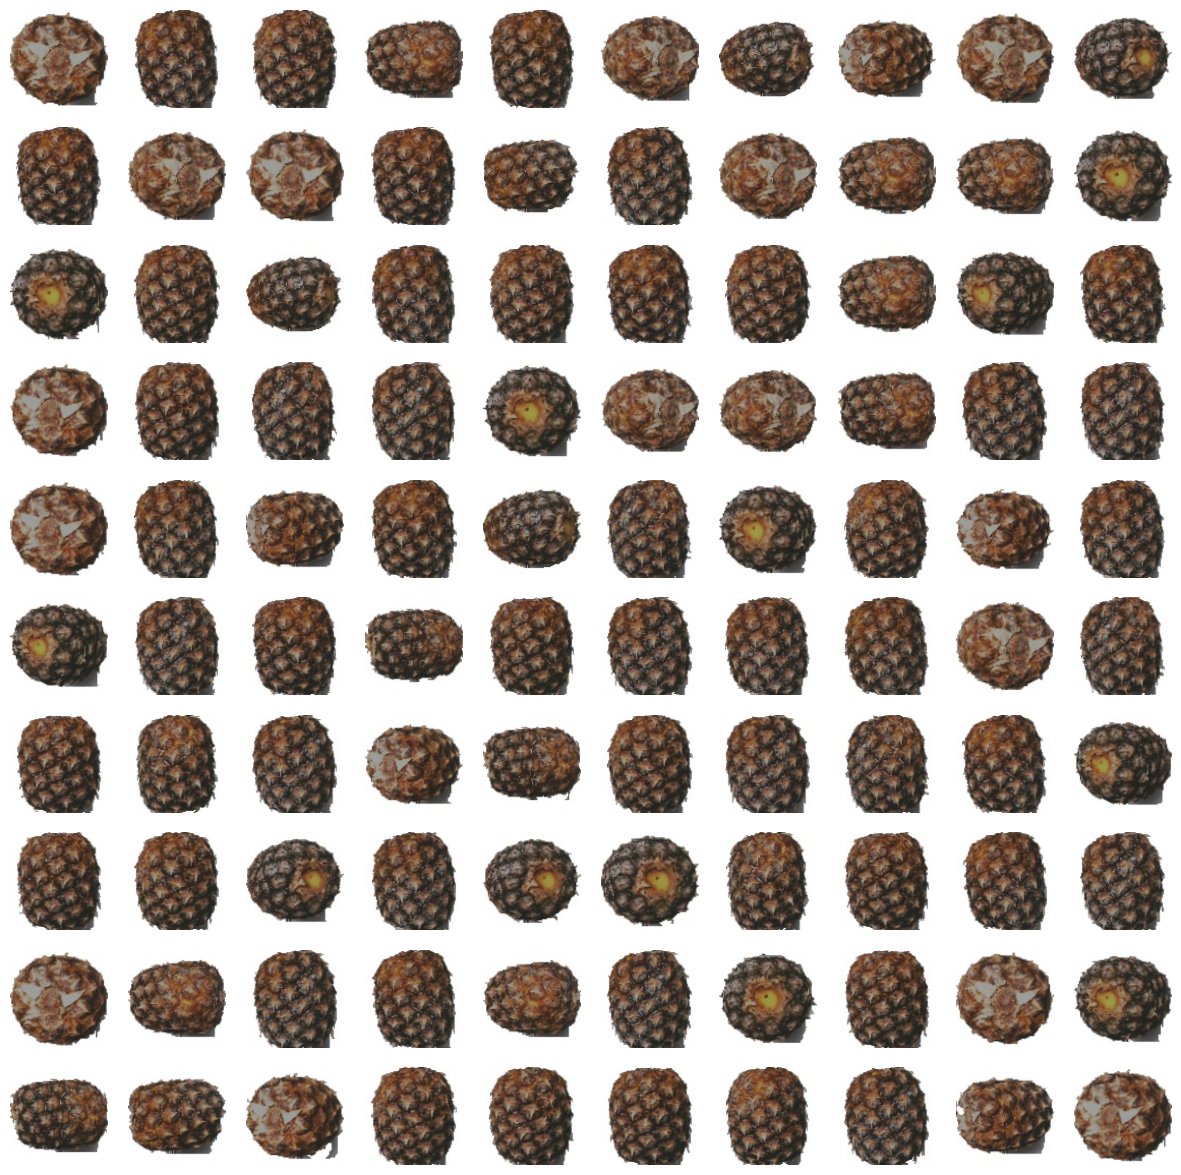

In [4]:
# Vizualizare imagini
def plot_image_grid(images, nb_rows, nb_cols, figsize=(15, 15)):
    assert len(images) == nb_rows*nb_cols, "Number of images should be the same as (nb_rows*nb_cols)"
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=figsize)
    
    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].axis('off')
            axs[i, j].imshow(images[n])
            n += 1

# Plotare imagini
print(fruits[y_train[0]])
plot_image_grid(X_t[0:100], 10, 10)

### Echilibrul Setului de Date

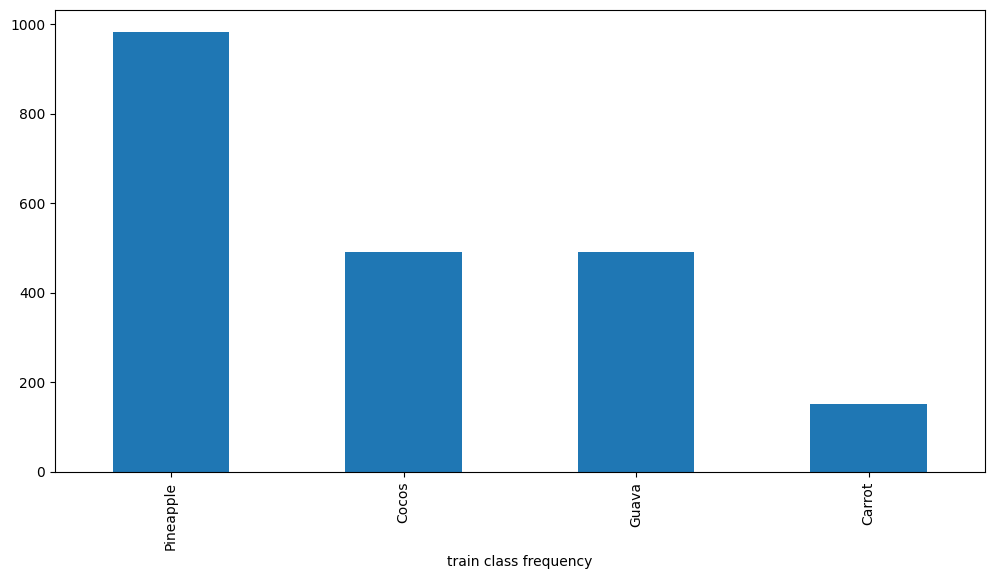

In [5]:
# Analiza echilibrului setului de date de antrenare
y_train2 = [fruits[i] for i in y_train]
df = pd.DataFrame(y_train2, columns=['train class frequency'])
df_freq = df['train class frequency'].value_counts()

ax = df_freq.plot.bar(x='train', y='frequency', rot=90, figsize=(12, 6))

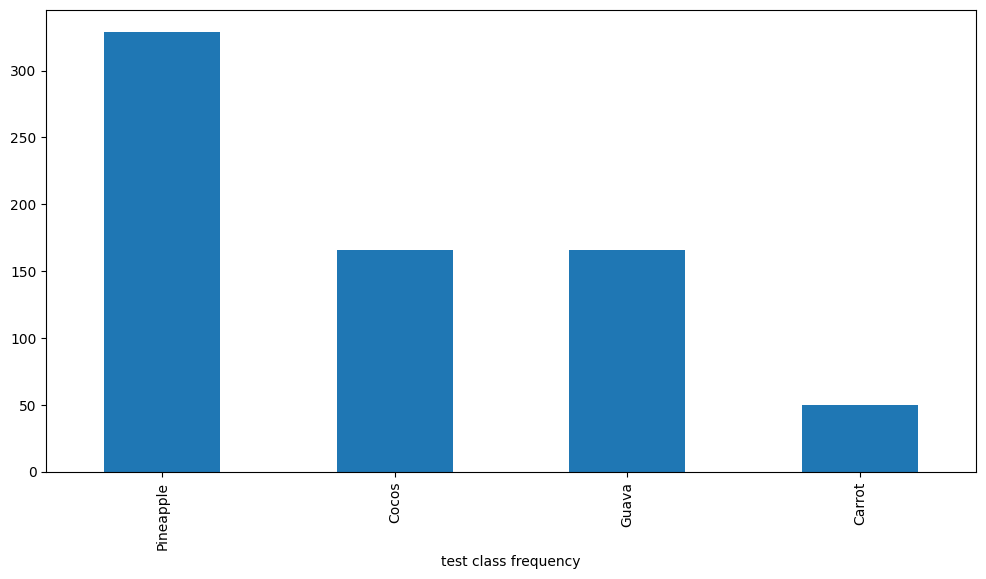

In [6]:
# Analiza echilibrului setului de date de testare
y_test2 = [fruits[i] for i in y_test]
df_test = pd.DataFrame(y_test2, columns=['test class frequency'])
df_test_freq = df_test['test class frequency'].value_counts()

ax = df_test_freq.plot.bar(x='class', y='frequency', rot=90, figsize=(12, 6))

In [7]:
# Cele mai numeroase 10 clase
print(df_freq.sort_values())
top_classes = list(df_freq.sort_values().tail(3).index)
print(f'\nTop classes: {top_classes}')

train class frequency
Carrot       151
Cocos        490
Guava        490
Pineapple    983
Name: count, dtype: int64

Top classes: ['Cocos', 'Guava', 'Pineapple']


### Standardizarea Datelor

In [8]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)

### Extragerea Atributelor - PCA

In [9]:
def getClassNumber(y):
    v =[]
    i=0
    count = 0
    for index in y:
        if(index == i):
            count +=1
        else:
            v.append(count)
            count = 1
            i +=1
    v.append(count)        
    return v

def plotPrincipalComponents(X, dim):
    v = getClassNumber(y_train)
    colors = 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'grey', 'orange', 'purple'
    markers = ['o', 'x' , 'v', 'd']
    tot = len(X)
    start = 0 
    if(dim == 2):
        for i,index in enumerate(v):
            end = start + index
            plt.scatter(X[start:end,0],X[start:end,1] , color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        plt.xlabel('PC1')
        plt.ylabel('PC2')
    
    if(dim == 3):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        for i,index in enumerate(v):
            end = start + index
            ax.scatter(X[start:end,0], X[start:end,1], X[start:end,2], color=colors[i%len(colors)], marker=markers[i%len(markers)], label = fruits[i])
            start = end
        ax.set_xlabel('PC1')
        ax.set_ylabel('PC2')
        ax.set_zlabel('PC3')


    plt.legend(loc='lower left')
    plt.xticks()
    plt.yticks()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = unique_labels(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=fruits, yticklabels=fruits,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return cm,ax

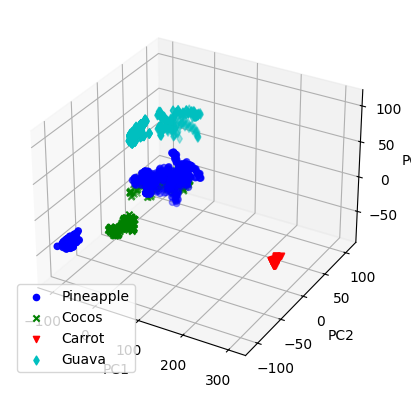

In [10]:
# vizualizarea datelor in spatiul 3D
pca = PCA(n_components=3)
dataIn3D = pca.fit_transform(X_train)
plotPrincipalComponents(dataIn3D, 3)

Aplicam PCA pe setul de date

In [11]:
# Aplicați PCA pe datele de antrenament și testare
pca = PCA(n_components=20)
X_t20 = pca.fit_transform(scaled_X_train)
X_test20 = pca.transform(X_test)


#### Vizualizarea atributiilor extrase

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-8..1].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3..1].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1..1].


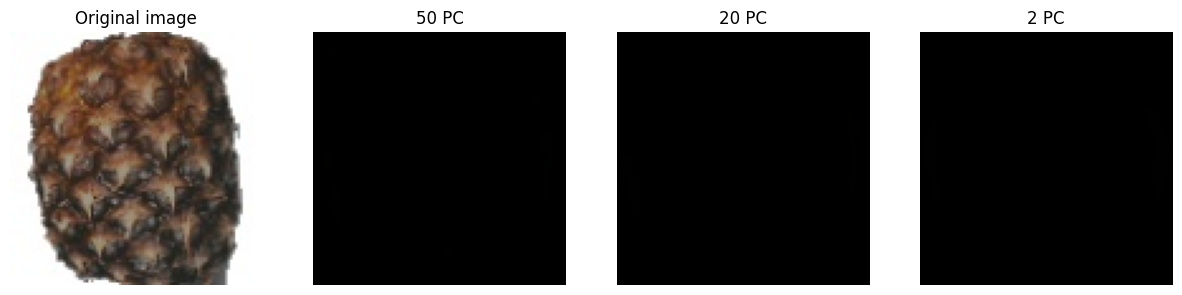

In [12]:
def showPCA(image,X2, X10, X50):
    fig = plt.figure(figsize=(15,15))
    ax1 = fig.add_subplot(1,4,1)
    ax1.axis('off')
    ax1.set_title('Original image')
    plt.imshow(image)
    ax1 = fig.add_subplot(1,4,2)
    ax1.axis('off') 
    ax1.set_title('50 PC')
    plt.imshow(X50)
    ax1 = fig.add_subplot(1,4,3)
    ax1.axis('off') 
    ax1.set_title('20 PC')
    plt.imshow(X10)
    ax2 = fig.add_subplot(1,4,4)
    ax2.axis('off') 
    ax2.set_title('2 PC')
    plt.imshow(X2)
    plt.show()

def computePCA(n, im_scaled, image_id):
    pca = PCA(n)
    principalComponents = pca.fit_transform(im_scaled)
    im_reduced = pca.inverse_transform(principalComponents)
    newImage = scaler.inverse_transform(im_reduced[image_id].reshape(1, -1))
    return newImage


################################################
# Show PCA
image = X_t[1]
X2 = computePCA(2, X_train, 1)
X20 = computePCA(20, X_train, 1)
X50 = computePCA(50, X_train, 1)

#Reshape in order to plot images
X2 = np.reshape(X2, (dim,dim,3)).astype(int)
X20 = np.reshape(X20, (dim,dim,3)).astype(int)
X50 = np.reshape(X50, (dim,dim,3)).astype(int)

showPCA(image, X2, X20, X50)
################################################

# TODO: Vizualizare pe cele mai numeroase clase

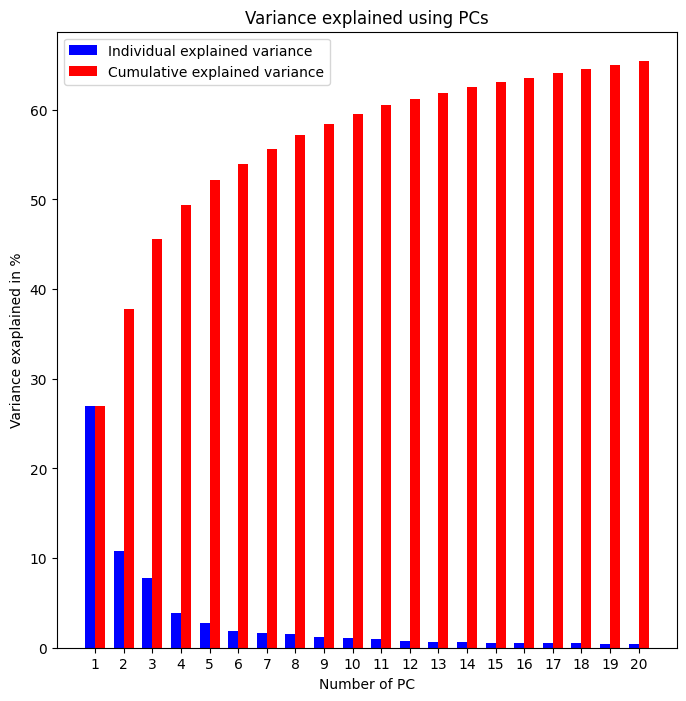

In [13]:
def showVariance(X_train):
    #Compute manually the principal components
    cov_matr=np.dot(X_train, X_train.T)
    eigval,eigvect=np.linalg.eig(cov_matr)

    index=np.argsort(eigval)[::-1] #take in order the index of ordered vector (ascending order)

    #eigvect[:,i] is associated to eigval[i] so 
    eigvect=eigvect[:,index]
    eigval=eigval[index]

    n_PC=[]
    var_explained=[]
    var_temp=[]
    var_tmp=0
    for i in range(20):
        var_tmp=var_tmp+eigval[i]
        n_PC.append(i)
        var_temp.append(eigval[i]/(eigval.sum())*100)
        var_explained.append(var_tmp/(eigval.sum())*100)

    fig, ax = plt.subplots(figsize=(8,8))

    ind = np.arange(20)    
    width = 0.35         # the width of the bars
    p1 = ax.bar(ind, var_temp, width, color='b')
    p2 = ax.bar(ind + width, var_explained, width, color='r')

    ax.legend((p1[0], p2[0]), ('Individual explained variance', 'Cumulative explained variance'))

    ax.set_title('Variance explained using PCs')
    ax.set_xticks(ind + width / 2)
    ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'))

    plt.xlabel('Number of PC')
    plt.ylabel('Variance exaplained in %')

    ax.autoscale_view()

    plt.show()

# Plotarea viariantei
showVariance(X_train)

### Selectia Atributelor - HOG 

In [14]:
# Importare librării
from skimage.transform import resize
from skimage.feature import hog

In [15]:
# Vizualizare atribute extrase
def showHOG(X_train, X_resized, X_hog):
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(X_train[0], cmap="gray")
    plt.title("original")
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(X_resized[0], cmap="gray")
    plt.title("resized")
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(X_hog[0], cmap="gray")
    plt.title("hog")
    plt.show()

# Redimensionarea unei imagini
def resize_image(img):
    resized_img = resize(img, (128, 64))
    return resized_img

# Aplicare hog
def apply_hog(resized_img):
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(8, 8),
                	cells_per_block=(2, 2), visualize=True, channel_axis=-1)
    return fd, hog_image

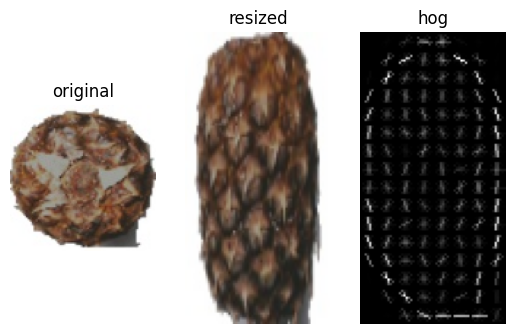

In [16]:
# Procesare si vizualizare a algoritmului hog
X_resized = np.array(list(map(resize_image, X_t)))
tuple_list = list(map(apply_hog, X_resized))

X_trainHOG = np.array([i[0] for i in tuple_list])
X_hog_image = np.array([i[1] for i in tuple_list])

# Aplicare HOG pe setul de testare
X_resized = np.array(list(map(resize_image, X_testt)))
tuple_list = list(map(apply_hog, X_resized))
X_testHOG = np.array([i[0] for i in tuple_list])

# TODO: vizualizare pe cele mai numeroase clase
showHOG(X_t, X_resized, X_hog_image)

(100, 100, 3)
(128, 64, 3)


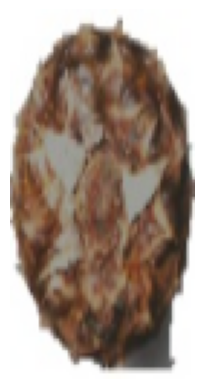

In [17]:
resized_img = resize(X_t[0], (128, 64))
plt.axis("off")
plt.imshow(resized_img)

print(X_t[0].shape)
print(resized_img.shape)

### Selectia Atributelor

In [18]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectPercentile, chi2

In [19]:
sel = VarianceThreshold(threshold=(0.01))
sel_percentile = SelectPercentile(chi2, percentile=80)
sel_percentile2 = SelectPercentile(percentile=80)

print(f'PCA: X shape before applying variance threashold: {X_t20.shape}')
X_t20_scaled = sel.fit_transform(X_t20)
print(f'PCA: X shape after applying variance threashold: {X_t20_scaled.shape}')
X_t20_scaled = sel_percentile2.fit_transform(X_t20, y_train)
X_test20_scaled = sel_percentile2.fit_transform(X_test20, y_test)
print(f'PCA: X shape after applying percentile selector: {X_t20_scaled.shape}')

print(f'\nHOG: X shape before applying variance threashold: {X_trainHOG.shape}')
X_trainHOG_scaled1 = sel.fit_transform(X_trainHOG)
X_testHOG_scaled1 = sel.transform(X_testHOG)
print(f'HOG: X shape after applying variance selector: {X_trainHOG_scaled1.shape}')
X_trainHOG_scaled = sel_percentile2.fit_transform(X_trainHOG, y_train)
X_testHOG_scaled = sel_percentile2.fit_transform(X_testHOG, y_test)
print(f'HOG: X shape after applying percentile selector: {X_trainHOG_scaled.shape}')

PCA: X shape before applying variance threashold: (2114, 20)
PCA: X shape after applying variance threashold: (2114, 20)
PCA: X shape after applying percentile selector: (2114, 16)

HOG: X shape before applying variance threashold: (2114, 3780)
HOG: X shape after applying variance selector: (2114, 852)
HOG: X shape after applying percentile selector: (2114, 3024)


In [52]:
# Impartirea setului de date
X_train_final_hog, X_validation_hog, y_train_final_hog, y_validation_hog = train_test_split(X_trainHOG_scaled1, y_train) 
X_train_final_pca, X_validation_pca, y_train_final_pca, y_validation_pca = train_test_split(X_t20_scaled, y_train) 


### Antrenarea Modelelor

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingRandomSearchCV, HalvingGridSearchCV

#### Antrenare modele folosind atributele PCA

In [56]:
# TODO
# Logistic Regression + PCA
clf = LogisticRegression(random_state=16, max_iter=1000)
clf = clf.fit(X_t20_scaled, y_train)
test_predictions = clf.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Logistic Regression considering first 20PC: {0:.2f}%".format(precision))

# Logistic Regression + PCA without feature filtering
clf = clf.fit(X_t20, y_train)
test_predictions_unscaled = clf.predict(X_test20)
LG_precision_unscaled = metrics.accuracy_score(test_predictions_unscaled, y_test) * 100

# SVM + PCA
svm = SVC(gamma=0.01, kernel='poly', probability=True)
svm = svm.fit(X_t20_scaled, y_train) 
test_predictions = svm.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM considering first 20PC: {0:.2f}%".format(precision))

# SVM + PCA unscaled
svm = svm.fit(X_t20, y_train)
test_predictions = svm.predict(X_test20)
SVM_precision_unscaled = metrics.accuracy_score(test_predictions, y_test) * 100

# Random Forest + PCA
random_forest = RandomForestClassifier(max_depth=20, random_state=19)
random_forest = random_forest.fit(X_t20_scaled, y_train)
test_predictions = random_forest.predict(X_test20_scaled)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Random Forest considering first 20PC: {0:.2f}%".format(precision))

# Random Forest + PCA unscaled
random_forest = random_forest.fit(X_t20, y_train)
test_predictions = random_forest.predict(X_test20)
RF_precision_unscaled = metrics.accuracy_score(test_predictions, y_test) * 100

print("\nAccuracy with Logistic Regression unscaled: {0:.2f}%".format(LG_precision_unscaled))
print("Accuracy with SVM considering unscaled: {0:.2f}%".format(SVM_precision_unscaled))
print("Accuracy with Random Forest unscaled: {0:.2f}%".format(RF_precision_unscaled))

Accuracy with Logistic Regression considering first 20PC: 94.51%
Accuracy with SVM considering first 20PC: 94.51%
Accuracy with Random Forest considering first 20PC: 95.92%

Accuracy with Logistic Regression unscaled: 96.77%
Accuracy with SVM considering unscaled: 96.20%
Accuracy with Random Forest unscaled: 97.33%


##### Logistic Regression

In [ ]:
# Hyperparameter Tunning
param_grid = [
    {'penalty':['l1','l2'],
    'C' : np.logspace(-4,4,20),
    'solver': ['liblinear'],
    'max_iter'  : [5000, 10000, 15000],
    'multi_class' : ['ovr', 'multinomial']
    },
    {'penalty':['l2'],
    'C' : np.logspace(-4,4,20),
    'solver': ['lbfgs', 'newton-cg', 'sag'],
    'max_iter'  : [5000, 10000, 15000],
    'multi_class' : ['ovr', 'multinomial']
    },
    {'penalty':['elasticnet'],
    'C' : np.logspace(-4,4,20),
    'solver': ['saga'],
    'max_iter'  : [5000, 10000, 15000],
    'l1_ratio' : [0.1, 0.5, 0.7, 0.9],
    'multi_class' : ['ovr', 'multinomial']
    }
]

grid = GridSearchCV(LogisticRegression(), param_grid, n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: Future

In [24]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("\n\nAccuracy with Logistic Regression considering first 20PC: {0:.2f}%".format(precision))
print(grid.best_params_)



Accuracy with Logistic Regression considering first 20PC: 94.94%
{'C': np.float64(1.623776739188721), 'max_iter': 5000, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}


##### SVM

In [ ]:
# Hyperparameter Tunning
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['poly', 'rbf'],
              'random_state': [0, 16, 19] 
            }
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 1/5] END C=0.01, gamma=1, kernel=poly, random_state=0;, score=1.000 total time=   0.0s
[CV 2/5] END C=0.01, gamma=1, kernel=poly, random_state=0;, score=1.000 total time=   0.0s
[CV 5/5] END C=0.01, gamma=1, kernel=poly, random_state=0;, score=1.000 total time=   0.0s
[CV 2/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.0s
[CV 3/5] END C=0.01, gamma=1, kernel=poly, random_state=0;, score=1.000 total time=   0.0s
[CV 1/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.0s
[CV 4/5] END C=0.01, gamma=1, kernel=poly, random_state=0;, score=1.000 total time=   0.0s
[CV 3/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.0s
[CV 4/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.0s
[CV 5/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.0s
[CV 2/5] END C=0.01, g

In [26]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("\n\nAccuracy with SVM considering first 20PC: {0:.2f}%".format(precision))
print(grid.best_params_)



Accuracy with SVM considering first 20PC: 94.51%
{'C': 0.01, 'gamma': 1, 'kernel': 'poly', 'random_state': 0}


##### Random Forest

In [37]:
# Hyperparameter Tunning
param_grid = { 
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [5, 8, 12, 15],
    'max_samples': [0.5, 0.7, 0.9, 1.0]
} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3, n_jobs=-1)
grid.fit(X_validation_pca, y_validation_pca)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_pca, y_train_final_pca)
y_pred = model.predict(X_test20_scaled)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 5/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.981 total time=   0.0s
[CV 3/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.981 total time=   0.0s
[CV 4/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.972 total time=   0.0s
[CV 2/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=1.000 total time=   0.1s
[CV 1/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.991 total time=   0.1s
[CV 2/5] END max_depth=5, max_samples=0.7, n_estimators=25;, score=1.000 total time=   0.0s
[CV 5/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=0.981 total time=   0.1s
[CV 1/5] END max_depth=5, max_samples=0.7, n_estimators=25;, score=0.991 total time=   0.1s
[CV 2/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=0.981 total time=   0.1s
[CV 3/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=0.991 total time=   0.1s
[CV 1/5] END max_d

In [38]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Random Forest considering first 20PC: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Random Forest considering first 20PC: 97.19%
{'max_depth': 12, 'max_samples': 0.9, 'n_estimators': 50}


##### Gradient Boosted Trees

In [ ]:
# Hyperparameter Tunning

In [30]:
# Evaluate model

#### Antrenare modele folosind atributele HOG

In [39]:
# TODO
# Logistic Regression + HOG
clf = LogisticRegression(random_state=16, max_iter=200)
clf = clf.fit(X_trainHOG_scaled1, y_train)
test_predictions = clf.predict(X_testHOG_scaled1)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Logistic Regression and hog: {0:.2f}%".format(precision))

# SVM + HOG
svm = SVC(gamma=0.01, kernel='rbf', probability=True)
svm = svm.fit(X_trainHOG_scaled1, y_train) 
test_predictions = svm.predict(X_testHOG_scaled1)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with SVM and hog: {0:.2f}%".format(precision))

# Random Forest + HOG
random_forest = RandomForestClassifier(max_depth=12, random_state=19)
random_forest = random_forest.fit(X_trainHOG_scaled1, y_train)
test_predictions = random_forest.predict(X_testHOG_scaled1)
precision = metrics.accuracy_score(test_predictions, y_test) * 100
print("Accuracy with Random Forest and hog: {0:.2f}%".format(precision))

# Gradient Boosted Trees + HOG

Accuracy with Logistic Regression and hog: 97.89%
Accuracy with SVM and hog: 98.31%
Accuracy with Random Forest and hog: 99.72%


##### Logistic Regression

In [53]:
# Hyperparameter Tunning
param_grid = [
    {'C' : [0.2, 0.5, 1.0],
    'multi_class' : ['ovr', 'multinomial', None],
    'max_iter': [200, 300],
    'random_state': [0, 10, 16]
    }
]

grid = HalvingGridSearchCV(LogisticRegression(), param_grid, n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/anami/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1256: Future

In [55]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Logistic Regression and HOG: 97.47%
{'C': 0.5, 'max_iter': 300, 'multi_class': 'ovr', 'random_state': 0}


##### SVM

In [ ]:
# Hyperparameter Tunning
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['poly', 'rbf'],
              'random_state': [0, 16, 19] 
            }
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

Fitting 5 folds for each of 180 candidates, totalling 900 fits
[CV 4/5] END C=0.01, gamma=1, kernel=poly, random_state=0;, score=1.000 total time=   0.1s
[CV 1/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.1s
[CV 2/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.1s
[CV 3/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.1s
[CV 2/5] END C=0.01, gamma=1, kernel=poly, random_state=19;, score=1.000 total time=   0.1s
[CV 5/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.1s
[CV 1/5] END C=0.01, gamma=1, kernel=poly, random_state=19;, score=1.000 total time=   0.1s
[CV 5/5] END C=0.01, gamma=1, kernel=poly, random_state=19;, score=1.000 total time=   0.1s
[CV 1/5] END C=0.01, gamma=1, kernel=poly, random_state=0;, score=1.000 total time=   0.1s
[CV 4/5] END C=0.01, gamma=1, kernel=poly, random_state=16;, score=1.000 total time=   0.1s
[CV 3/5] END C=0.01

/home/anami/.local/lib/python3.11/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [58]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Logistic Regression and HOG: 98.17%
{'C': 0.01, 'gamma': 1, 'kernel': 'poly', 'random_state': 0}


##### Random Forest

In [59]:
# Hyperparameter Tunning
param_grid = { 
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [5, 8, 12, 15],
    'max_samples': [0.5, 0.7, 0.9, 1.0]
} 

grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3, n_jobs=-1)
grid = grid.fit(X_validation_hog, y_validation_hog)

# Training model
model = grid.best_estimator_
model = model.fit(X_train_final_hog, y_train_final_hog)
y_pred = model.predict(X_testHOG_scaled1)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 2/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.962 total time=   0.1s
[CV 4/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.991 total time=   0.1s
[CV 3/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.991 total time=   0.1s[CV 1/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.981 total time=   0.1s

[CV 5/5] END max_depth=5, max_samples=0.5, n_estimators=25;, score=0.990 total time=   0.2s
[CV 5/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=1.000 total time=   0.2s
[CV 2/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=0.981 total time=   0.2s
[CV 1/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=0.981 total time=   0.3s
[CV 3/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=1.000 total time=   0.3s
[CV 4/5] END max_depth=5, max_samples=0.5, n_estimators=50;, score=0.991 total time=   0.3s
[CV 1/5] END max_d

In [60]:
# Evaluate model
precision = metrics.accuracy_score(y_pred, y_test) * 100
print("Accuracy with Logistic Regression and HOG: {0:.2f}%".format(precision))
print(grid.best_params_)

Accuracy with Logistic Regression and HOG: 97.89%
{'max_depth': 8, 'max_samples': 1.0, 'n_estimators': 25}


##### Gradient Boosted Trees

In [ ]:
# Hyperparameter Tuning

In [ ]:
# Evaluate model

---
## Fashion-MNIST

### Procesare Set de Date

In [ ]:
import mnist_reader

X_train, y_train = mnist_reader.load_mnist('input/fashion', kind='train')
X_test, y_test = mnist_reader.load_mnist('input/fashion', kind='t10k')

### Echilibrul Setului de Date

### Extragerea Atributelor - 1

### Extragerea Atributelor - 2

### Standardizarea Setului de Date

### Antrenarea Modelelor